### S&P 500 Free Cash Flow

Brian Dew

December 10, 2018

@bd_econ

----
Goal: Calculate free cash flow for S&P 500 companies then graph. 

Originally published by People's Policy Project and republished by Jacobin.

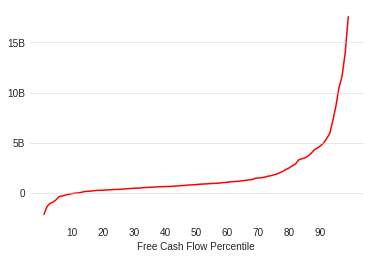

In [5]:
import pandas as pd
import numpy as np

# Graph settings:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
mpl.rc('figure', figsize=[14, 12])
plt.rc('axes', axisbelow=True)
%matplotlib inline

# Get list of S&P 500 companies from wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tickers = list(sp500[0].iloc[1:, 0])

# Scrape Yahoo! Finance Cash Flow tables
d = {}
for T in tickers:
    url = f'https://finance.yahoo.com/quote/{T}/cash-flow?p={T}'
    tables = pd.read_html(url)
    table = tables[0].set_index(0)
    d[T] = {}
    for col in table:
        year = pd.to_datetime(table.loc['Period Ending', col]).year
        tcfoa = float(table.loc['Total Cash Flow From Operating Activities', col])
        capex = table.loc['Capital Expenditures', col]
        if capex == '-':
            capex = 0
        else:
            capex = float(capex)
        fcf = tcfoa + capex
        d[T][year] = {'TCFOA': tcfoa, 'CAPEX': capex, 'FCF': fcf}
        
# Add in sector
sector = {row[0]: row[3] for index, row in sp500[0].iloc[1:].iterrows()}

for k, v in d.items():
    v['Sector'] = sector[k]
    
FCF = [(k, v[2017]['FCF']) for k, v in d.items() 
       if v['Sector'] != 'Financials' and 2017 in v.keys()]

df = pd.DataFrame(FCF).set_index(0).sort_values(by=1)

df = df.drop('GOOGL') # Google is listed twice (class A and class C)

pts = np.arange(0.01, 1, 0.01)

ax = df.divide(1_000_000).quantile(pts).plot(color='red', legend=None)
yticks = [0, 5, 10, 15]
ylabels = ['0'] + [f'{yt}B' for yt in yticks if yt > 0]
for hval in yticks:
    ax = plt.axhline(hval, color='lightgray', linewidth=0.5)
ax = plt.yticks(yticks, ylabels)
ax = plt.xticks(np.arange(0.1, 1, 0.1), np.arange(10, 100, 10))
ax = plt.xlabel('Free Cash Flow Percentile')
plt.savefig('FCF_percentile.png', bbox_inches='tight', dpi=100)